In [1]:
import numpy as np
from scipy import sparse
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import os
import matplotlib.pyplot as plt

In [2]:
trace_directory = './heatmap_generators/plot-trace/'
heat_matrix_directory = './heat-matrices/'

In [3]:
def getSparse (matrix):
    row,col,val = np.array([],), np.array([]), np.array([])
    shape = matrix.shape
    num_rows = shape[0]
    num_cols = shape[1]

    for i in range(num_rows):
        for j in range(num_cols):
            if matrix[i,j] != 0:
                row = np.append(row,[i],axis = 0)
                col = np.append(col,[j], axis = 0)
                val = np.append(val, [matrix[i,j]])
    return row, col, val

In [4]:
dims = (1024,1024)
num_per_subblock = 128
errors1 = []
errors2 = []
errors3 = []
errors4 = []
errors5 = []
errors6 = []

In [28]:
#For extracting the data from the traces in the format Sam's code expects it, only needs to be run once
for filename in os.listdir(trace_directory):
    f = open(trace_directory + filename)
    num_lines = len(f.readlines())
    num_time_blocks = int(num_lines/(dims[1]*num_per_subblock))
    f.close()
    f = open(trace_directory + filename)
    line = f.readline().split()
    tag, loc = line[0],line[1]
    modpart = line[1][11:14]
    modpart = int(modpart,16)%1024
    misses = []
    totals = []

    for time_block in range(num_time_blocks):
        miss = 0
        total = 0
        table = np.zeros(dims)

        for time_subblock in range(dims[1]):
            for i in range(num_per_subblock):
                line = f.readline().split()
                tag, loc = line[0],line[1]
                modpart = line[1][11:14]
                modpart = int(modpart,16)%dims[0]
                table[modpart,time_subblock]+=1
                if tag == "M":
                    miss +=1
                total += 1

        misses.append(miss)
        totals.append(total)

        fourier = np.fft.fft2(table)
        fourier = abs(fourier)
        nth_largest = sorted(list(set(fourier.flatten().tolist())))[-512]
        fourier[fourier <= nth_largest] = 0
        row,col,val = getSparse(fourier)
        sfourier = sparse.coo_matrix((val, (row, col)), shape=(dims[0], dims[1]))
        sfourier = sfourier.reshape((1,1024*1024))
        if time_block == 0:
            data = sfourier
        else:
            data = sparse.vstack((data,sfourier))

    with open(heat_matrix_directory + filename + '-heatmatrix.npy', 'wb') as outfile:
        np.save(outfile, data.toarray())
        np.save(outfile, np.array(totals))
        np.save(outfile, np.array(misses))

    print("Finished File: " + filename)
    f.close()

Finished File: 620.omnetpp_s-874B.champsimtrace.xz-L1D
Finished File: 657.xz_s-3167B.champsimtrace.xz-L1D
Finished File: 605.mcf_s-665B.champsimtrace.xz-L1D
Finished File: 623.xalancbmk_s-700B.champsimtrace.xz-L1D
Finished File: 648.exchange2_s-1699B.champsimtrace.xz-L1D
Finished File: 619.lbm_s-4268B.champsimtrace.xz-L1D
Finished File: 602.gcc_s-734B.champsimtrace.xz-L1D
Finished File: 621.wrf_s-575B.champsimtrace.xz-L1D
Finished File: 631.deepsjeng_s-928B.champsimtrace.xz-L1D
Finished File: 600.perlbench_s-210B.champsimtrace.xz-L1D
Finished File: 607.cactuBSSN_s-2421B.champsimtrace.xz-L1D
Finished File: 649.fotonik3d_s-1176B.champsimtrace.xz-L1D
Finished File: 641.leela_s-800B.champsimtrace.xz-L1D
Finished File: 627.cam4_s-573B.champsimtrace.xz-L1D
Finished File: 644.nab_s-5853B.champsimtrace.xz-L1D
Finished File: 628.pop2_s-17B.champsimtrace.xz-L1D
Finished File: 603.bwaves_s-3699B.champsimtrace.xz-L1D
Finished File: 654.roms_s-842B.champsimtrace.xz-L1D
Finished File: 625.x264_s-18B

In [27]:
all_errors = []
for n_train in range(7):
    train_heatmaps = []
    test_heatmaps = []

    train_totals = []
    test_totals = []

    train_misses = []
    test_misses = []

    idx = 0
    for filename in sorted(os.listdir(heat_matrix_directory)):
        if(filename == '.DS_Store'):
            continue
        with open(heat_matrix_directory + filename, 'rb') as f:
            heatmap = np.load(f)
            total = np.load(f)
            miss = np.load(f)

            if idx <= n_train:
                train_heatmaps.append(heatmap)
                train_totals.append(total)
                train_misses.append(miss)
        idx += 1
    print("Got data for training")
    #Removing miss rates of 0 to avoid divide by zero errors for logistic regression
    train_X = np.concatenate(train_heatmaps, axis=0)
    train_totals = np.concatenate(train_totals, axis=0) if len(train_totals) > 1 else train_totals[0]
    train_misses = np.concatenate(train_misses, axis=0) if len(train_misses) > 1 else train_misses[0]

    train_cleaning_matrix = np.concatenate([train_X, np.reshape(train_totals, (train_totals.shape[0],1)), np.reshape(train_misses, (train_misses.shape[0],1))], axis=1)
    train_cleaned = np.delete(train_cleaning_matrix, np.where(train_cleaning_matrix[:, -1] == 0)[0], axis=0)

    # Separating back out cleaned data
    train_X = train_cleaned[:, :-2]
    train_totals = train_cleaned[:, -2:-1]
    train_misses = train_cleaned[:,-1:]
    print("Cleaned data for training")

    #Converting to logits
    train_miss_rates = np.divide(train_misses, train_totals)
    train_odds = np.divide(train_miss_rates, 1 - train_miss_rates)
    train_logits = np.log(train_odds)
    print("Converted ground truth to logits")

    print("Fitting linear regression model...")
    #Fitting Linear Regression Model (to logits, so equivalent to logistic regression)
    lin_mod = Lasso(max_iter=10000).fit(train_X, train_logits)
    print("Model fitted!")

    print("Calculating errors...")
    model_errors = []
    for n_test in range(13,19):
        #Gathering test workload
        idx = 0
        test_X = None
        test_totals = None
        test_misses = None


        for filename in sorted(os.listdir(heat_matrix_directory)):
            if(filename == '.DS_Store'):
                continue
            with open(heat_matrix_directory + filename, 'rb') as f:
                heatmap = np.load(f)
                total = np.load(f)
                miss = np.load(f)

                if idx == n_test:
                    test_X = heatmap
                    test_totals = total
                    test_misses = miss
            idx += 1
        print("Gathered data for workload number " + str(n_test))

        #Removing miss rates of 0 to avoid divide by zero errors for logistic regression
        test_cleaning_matrix = np.concatenate([test_X, np.reshape(test_totals, (test_totals.shape[0], 1)),
                                               np.reshape(test_misses, (test_misses.shape[0], 1))], axis=1)
        test_cleaned = np.delete(test_cleaning_matrix, np.where(test_cleaning_matrix[:, -1] == 0)[0], axis=0)

        # Separating back out cleaned data
        test_X = test_cleaned[:, :-2]
        test_totals = test_cleaned[:, -2:-1]
        test_misses = test_cleaned[:,-1:]
        print("Cleaned test workload data")

        #Converting to logits
        test_miss_rates = np.divide(test_misses, test_totals)
        test_odds = np.divide(test_miss_rates, 1 - test_miss_rates)
        test_logits = np.log(test_odds)
        print("Converted test ground truth to logits")

        print("Predicting using test data...")
        #Predict using model and calculate error
        test_pred_logit = lin_mod.predict(test_X)
        total = 0
        print("Done!")

        print("Calculating errors...")
        for i, x in enumerate(test_pred_logit):
            N = test_totals[i]
            m = test_misses[i]
            error = ((N * np.log(1 + np.exp(x))) - (m * x) + (m * np.log(m/N)) + ((N - m) * np.log(1 - (m/N))))/N
            norm = np.linalg.norm(lin_mod.coef_, ord=1)
            total += error
        print("Done!")
        model_errors.append(total[0])
    all_errors.append(model_errors)
    print("Finished with model fit on " + str(n_train + 1) + " workloads")
    print("Errors: " + str(model_errors))

Got data for training
Cleaned data for training
Converted ground truth to logits
Fitting linear regression model...
Model fitted!
Calculating errors...
Gathered data for workload number 13
Cleaned test workload data
Converted test ground truth to logits
Predicting using test data...
Done!
Calculating errors...
Done!
Gathered data for workload number 14
Cleaned test workload data
Converted test ground truth to logits
Predicting using test data...
Done!
Calculating errors...
Done!
Gathered data for workload number 15
Cleaned test workload data
Converted test ground truth to logits
Predicting using test data...
Done!
Calculating errors...
Done!
Gathered data for workload number 16
Cleaned test workload data
Converted test ground truth to logits
Predicting using test data...
Done!
Calculating errors...
Done!
Gathered data for workload number 17
Cleaned test workload data
Converted test ground truth to logits
Predicting using test data...
Done!
Calculating errors...
Done!
Gathered data for 

In [29]:
numpy_errors = np.array(all_errors)
numpy_errors = np.transpose(numpy_errors)

plot_errors = []
for i in range(numpy_errors.shape[0]):
    plot_errors.append(numpy_errors[i,:])

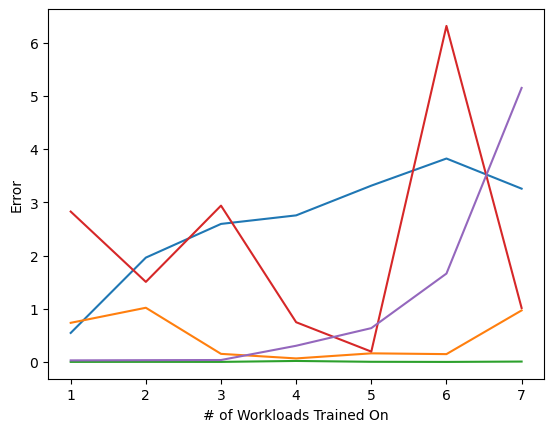

In [35]:
x = np.arange(1,8)
for i in range(len(plot_errors)):
    if i == 2:
        continue
    y = plot_errors[i]
    plt.plot(x, y)
    plt.xlabel('# of Workloads Trained On')
    plt.ylabel('Error')
plt.savefig('results.png')

In [10]:
n_train_reserve = 1

test_idx = 13
train_heatmaps = []
test_heatmaps = []

train_totals = []
test_totals = []

train_misses = []
test_misses = []

idx = 0
for filename in sorted(os.listdir(heat_matrix_directory)):
    if(filename == '.DS_Store'):
        continue
    with open(heat_matrix_directory + filename, 'rb') as f:
        heatmap = np.load(f)
        total = np.load(f)
        miss = np.load(f)

        if idx < n_train_reserve:
            train_heatmaps.append(heatmap)
            train_totals.append(total)
            train_misses.append(miss)
        elif idx == test_idx:
            test_X = heatmap
            test_totals = total
            test_misses = miss
    idx += 1

In [78]:
train_X = np.concatenate(train_heatmaps, axis=0)

train_totals = np.concatenate(train_totals, axis=0) if len(train_totals) > 1 else train_totals[0]

train_misses = np.concatenate(train_misses, axis=0) if len(train_misses) > 1 else train_misses[0]

#Removing miss rates of 0 to avoid divide by zero errors for logistic regression
train_cleaning_matrix = np.concatenate([train_X, np.reshape(train_totals, (train_totals.shape[0],1)), np.reshape(train_misses, (train_misses.shape[0],1))], axis=1)
test_cleaning_matrix = np.concatenate([test_X, np.reshape(test_totals, (test_totals.shape[0],1)), np.reshape(test_misses, (test_misses.shape[0],1))], axis=1)

train_cleaned = np.delete(train_cleaning_matrix, np.where(train_cleaning_matrix[:, -1] == 0)[0], axis=0)
test_cleaned = np.delete(test_cleaning_matrix, np.where(test_cleaning_matrix[:, -1] == 0)[0], axis=0)

In [79]:
# Separating back out cleaned data
train_X = train_cleaned[:, :-2]
test_X = test_cleaned[:, :-2]

train_totals = train_cleaned[:, -2:-1]
test_totals = test_cleaned[:, -2:-1]

train_misses = train_cleaned[:,-1:]
test_misses = test_cleaned[:,-1:]

In [80]:
train_miss_rates = np.divide(train_misses, train_totals)
test_miss_rates = np.divide(test_misses, test_totals)

train_odds = np.divide(train_miss_rates, 1 - train_miss_rates)
train_logits = np.log(train_odds)

test_odds = np.divide(test_miss_rates, 1 - test_miss_rates)
test_logits = np.log(test_odds)

In [74]:
lin_mod = Lasso(max_iter=10000).fit(train_X, train_logits)

In [81]:
test_pred_logit = lin_mod.predict(test_X)

# pred_odds = np.exp(test_pred_logit)
# truth_odds = np.exp(test_logits)
#
# y_truth = np.divide(truth_odds, 1 + truth_odds)
# y_hat = np.divide(pred_odds, 1 + pred_odds)
total = 0

for i, x in enumerate(test_pred_logit):
    N = test_totals[i]
    m = test_misses[i]
    error = ((N * np.log(1 + np.exp(x))) - (m * x) + (m * np.log(m/N)) + ((N - m) * np.log(1 - (m/N))))/N
    norm = np.linalg.norm(lin_mod.coef_, ord=1)
    total += error + norm

In [82]:
errors1.append(total[0])